<div style="text-align:center;">
    <h1 style="font-size: 25px;"><b>PROYECTO INDIVIDUAL 2: SINIESTROS VIALES EN CABA</h1>
</div>


<div style="text-align:center;">
<img src="https://chequeado.com/wp-content/uploads/2022/06/siniestro-viales-3.jpg   " alt="Siniestros viales" width="500" height="210">
</div>

                                    LIMPIEZA Y ANALISIS EXPLORATORIO DE LOS DATOS:


A continuación se presentan los procesos de ETL y EDA para los datos de Hechos y Víctimas, correspondientes a los acontecimientos de siniestros viales en la Ciudad Autónoma de Buenos Aires, periodo 2016 - 2021.

Se abordarán los accidentes letales, lugar del acontecimiento, tipo de victimas y vehículos involucrados. Ésta información se encuentra en las hojas de 'Hechos' y 'Víctimas', presentes en el libro de excel, 'homicidios', carpeta de 'Datos Iniciales'.

Con el tratamiento y análisis de estos datos se busca conocer los mayores focos en dónde suceden estos eventos, quienes son las principales víctimas, vehículos y condiciones de los accidentes. Toda esta información adquirida será, al final, transformada en conocimiento útil para la toma de decisiones y medidas en pro de reducir estos lamentables sucesos. 

In [91]:
import numpy as np
import pandas as pd
from datetime import datetime,time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

1). TABLA HECHOS:

Se cargan los datos para tener un primer panorama de los mismos:

In [92]:
hechos = pd.read_excel('../Datos Iniciales/homicidios.xlsx', sheet_name='HECHOS')
hechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [93]:
hechos.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO'],
      dtype='object')

Formateo de nombres de las columnas:

In [94]:
hechos = hechos.rename(columns=lambda x: ' '.join(word.capitalize() for word in x.split('_')))

hechos.columns


Index(['Id', 'N Victimas', 'Fecha', 'Aaaa', 'Mm', 'Dd', 'Hora', 'Hh',
       'Lugar Del Hecho', 'Tipo De Calle', 'Calle', 'Altura', 'Cruce',
       'Dirección normalizada', 'Comuna', 'Xy (caba)', 'Pos x', 'Pos y',
       'Participantes', 'Victima', 'Acusado'],
      dtype='object')

In [95]:
hechos = hechos.rename(columns = {'N victimas': 'Número de Víctimas','Aaaa':'Año',
                                  'Mm':'Mes','Dd':'Día','Hh':'Hora completa','Victima':'Víctima',
                                  'Dirección normalizada':'Dirección Normalizada','Pos x':'X','Pos y':'Y'})

    Busqueda de datos duplicados:

In [96]:
len(hechos['Id'].unique())

696

Se usa la funcion '*verifica_duplicados_por_columna*', para buscar duplicados a travez de una columna en específico de nuestro dataframe, en este caso a travez de la columna 'Id':


In [97]:
def verifica_duplicados_por_columna(df, columna):
    #Se buscan las filas fuplicadas en la columna :
    duplicated_rows = df[df.duplicated(subset=columna, keep=False)]
    if duplicated_rows.empty:
        return "No hay duplicados"
    
    #Se ordenan las filas duplicadas para comparar entre sí
    duplicated_rows_sorted = duplicated_rows.sort_values(by=columna)
    return duplicated_rows_sorted

In [98]:
verifica_duplicados_por_columna(hechos, 'Id')

'No hay duplicados'

Cómo se observa, no existen duplicados en nuestros datos.

    Tipo de datos:

La funcion verificar_tipo_datos() nos ayuda a analizar el tipo de datos de cada columna, adicionalmente, podemos conocer si existen o no nulos y el '%' que representan los mismos sobre el total de datos de la columna.

In [99]:
def verificar_tipo_datos(df):
    mi_dict = {"nombre_campo": [], "tipo_datos": [], "no_nulos_%": [], "nulos_%": [], "nulos": []}

    for columna in df.columns:
        porcentaje_no_nulos = (df[columna].count() / len(df)) * 100
        mi_dict["nombre_campo"].append(columna)
        mi_dict["tipo_datos"].append(df[columna].apply(type).unique())
        mi_dict["no_nulos_%"].append(round(porcentaje_no_nulos, 2))
        mi_dict["nulos_%"].append(round(100-porcentaje_no_nulos, 2))
        mi_dict["nulos"].append(df[columna].isnull().sum())

    df_info = pd.DataFrame(mi_dict)
        
    return df_info

In [100]:
verificar_tipo_datos(hechos)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.00,0.00,0
1,N Victimas,[<class 'int'>],100.00,0.00,0
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.00,0.00,0
3,Año,[<class 'int'>],100.00,0.00,0
4,Mes,[<class 'int'>],100.00,0.00,0
5,Día,[<class 'int'>],100.00,0.00,0
6,Hora,"[<class 'datetime.time'>, <class 'str'>, <clas...",100.00,0.00,0
7,Hora completa,"[<class 'int'>, <class 'str'>]",100.00,0.00,0
8,Lugar Del Hecho,[<class 'str'>],100.00,0.00,0
9,Tipo De Calle,[<class 'str'>],100.00,0.00,0


Como se observa, existen un toal de 747 valores nulos, que se encuentran en las columnas de altura, cruce y dirección normalizada.

Para el caso de la columna 'Altura' los datos faltantes representan el 81.5% de los datos, esto es casuado por el hecho de que estos datos informan en qué lugar de la calle ocurre el accidente, sin embargo, la mayoría de los accidentes ocurrieron en esquinas. Adicionalmente, podemos concer la altura con ayuda del 'Lugar del Hecho' y la 'Dirección'. Por lo tanto, no es un dato que aporte informacion considerable al análisis y se decide eliminar dicha columna del conjunt de datos. 

In [101]:

hechos.loc[hechos['Altura'].notnull(), ['Altura', 'Lugar Del Hecho', 'Dirección Normalizada']].head()


,Altura,Lugar Del Hecho,Dirección Normalizada
2,2034.0,AV ENTRE RIOS 2034,ENTRE RIOS AV. 2034
9,1366.0,AV ENTRE RIOS 1366,ENTRE RIOS AV. 1366
14,156.0,SUIPACHA 156,SUIPACHA 156
33,1483.0,LIMA 1483,LIMA 1483
42,30.0,AV LUIS MARIA CAMPOS 30,"CAMPOS, LUIS M. AV. 30"


Cómo se puede observar, para aquellas filas donde Altura tiene un dato no nulo, el dato existe en 'Lugar del hecho' y 'Dirección normalizada'

In [102]:
hechos=hechos.drop(columns='Altura')
hechos.columns

Index(['Id', 'N Victimas', 'Fecha', 'Año', 'Mes', 'Día', 'Hora',
       'Hora completa', 'Lugar Del Hecho', 'Tipo De Calle', 'Calle', 'Cruce',
       'Dirección Normalizada', 'Comuna', 'Xy (caba)', 'X', 'Y',
       'Participantes', 'Víctima', 'Acusado'],
      dtype='object')

Ahora, se analiza la columna 'Cruce', en la cual existen 24.57% de datos nulos, estos indican que el hecho no se dió en un cruce (intersección de dos o mas vías).

In [103]:

hechos.loc[hechos['Cruce'].notnull(), [ 'Cruce','Lugar Del Hecho', 'Dirección Normalizada','Tipo De Calle']].head()

,Cruce,Lugar Del Hecho,Dirección Normalizada,Tipo De Calle
0,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.",AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",AVENIDA
1,DE LOS CORRALES AV.,AV GRAL PAZ Y AV DE LOS CORRALES,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",GRAL PAZ
3,"VILLEGAS, CONRADO, GRAL.",AV LARRAZABAL Y GRAL VILLEGAS CONRADO,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",AVENIDA
4,"SAENZ PE?A, LUIS, PRES.",AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",AVENIDA
5,ESCALADA AV.,AV 27 DE FEBRERO Y AV ESCALADA,27 DE FEBRERO AV. y ESCALADA AV.,AVENIDA


Los anteriores, son ejemplos de sucesos en cruces viales.

In [104]:

hechos.loc[hechos['Cruce'].isnull(), [ 'Cruce','Lugar Del Hecho', 'Dirección Normalizada','Tipo De Calle']].head()

,Cruce,Lugar Del Hecho,Dirección Normalizada,Tipo De Calle
2,NaN,AV ENTRE RIOS 2034,ENTRE RIOS AV. 2034,AVENIDA
9,NaN,AV ENTRE RIOS 1366,ENTRE RIOS AV. 1366,AVENIDA
14,NaN,SUIPACHA 156,SUIPACHA 156,CALLE
33,NaN,LIMA 1483,LIMA 1483,CALLE
35,NaN,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI KM....,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,AUTOPISTA


Los anteriores, **no** son ejemplos de sucesos en cruces viales.

Por lo tanto, y para mayor legibilidad de los datos de esta columna, se procede a reemplazar los valores nulos por un NO (el accidente NO sucedió en un cruce), y los existentes por un SI (el accidente SÍ ocurrió en un cruce)

In [105]:
#no_nulos = SI || nulos = NO
hechos['Cruce'] = np.where(hechos['Cruce'].notnull(), 'SI', 'NO')
hechos[['Cruce', 'Lugar Del Hecho', 'Tipo De Calle','Dirección Normalizada']].head()

,Cruce,Lugar Del Hecho,Tipo De Calle,Dirección Normalizada
0,SI,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G..."
1,SI,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV. y DE LOS CORRALES AV."
2,NO,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV. 2034
3,SI,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL."
4,SI,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES."


De esta manera se sabe cuando el accidente ocurre en un cruce o no.

La tercera columna con datos faltantes es 'DIrección Normalizada', cuenta apenas con un 1.15% de valores nulos, correspondientes a 8 filas:

In [106]:

hechos.loc[hechos['Dirección Normalizada'].isnull(), [ 'Dirección Normalizada','Lugar Del Hecho' ,'Tipo De Calle']]

,Dirección Normalizada,Lugar Del Hecho,Tipo De Calle
38,NaN,AUTOPISTA LUGONES PK 10000,AUTOPISTA
106,NaN,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA
119,NaN,SD,CALLE
180,NaN,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA
181,NaN,AU DELLEPIANE 2400,AUTOPISTA
313,NaN,AUTOPISTA LUGONES KM 4.7,AUTOPISTA
546,NaN,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA
621,NaN,"AU BUENOS AIRES LA PLATA KM 4,5",AUTOPISTA


Como se observa, podemos rellenar estos datos con los de la columna 'Lugar del Hecho' correspondientes, ya que proporciona la informacion suficiente para saber dónde sucedió el accidente.

In [107]:
hechos['Dirección Normalizada'] = hechos['Dirección Normalizada'].fillna(hechos['Lugar Del Hecho'])
hechos['Dirección Normalizada'][[38,106,119,180,181,313,546,621]]

38                  AUTOPISTA LUGONES PK 10000
106           AU BUENOS AIRES - LA PLATA KM. 4
119                                         SD
180    AU PERITO MORENO Y RAMAL ENLACE AU1/AU6
181                         AU DELLEPIANE 2400
313                   AUTOPISTA LUGONES KM 4.7
546               LUGONES, LEOPOLDO AV. KM 6,1
621           AU BUENOS AIRES LA PLATA  KM 4,5
Name: Dirección Normalizada, dtype: object

In [108]:
hechos.loc[hechos['Calle'].isnull(), [ 'Dirección Normalizada','Calle','Lugar Del Hecho']]

,Dirección Normalizada,Calle,Lugar Del Hecho
119,SD,NaN,SD


Como no existen datos asociados, se asigna SD, sin dato, a esta posicion.

In [109]:
hechos['Calle'] = hechos['Calle'].fillna('SD')
hechos['Calle'][119]

'SD'

    Tipos de Dato por Columna:

Con lo observado gracias a la funcion 'verificar_tipo_de_dato', se tiene qué: 
Las columnas 'Hora', 'Hora Completa', 'Calle', 'Dirección Normalizada' y 'Cruce' tienen varios tipos de datos en la misma columna, 
por lo que se revisará una a una estas columnas para determinar un único tipo de dato.

En primer lugar, la columna 'Hora':

In [110]:
hechos['Hora'].apply(type).value_counts()

Hora
<class 'datetime.time'>        608
<class 'str'>                   85
<class 'datetime.datetime'>      3
Name: count, dtype: int64

La mayoría de los datos son de tipo 'datetime.time', convertimos la columna a este tipo:

In [111]:
def convert_to_time(to_time):
    if isinstance(to_time, str):
        try:
            return datetime.strptime(to_time, "%H:%M:%S").time()
        except ValueError:
            return None
    elif isinstance(to_time, datetime):
        return to_time.time()
    return to_time

In [112]:
hechos['Hora'] = hechos['Hora'].apply(convert_to_time)

In [113]:
hechos['Hora'].apply(type).value_counts()

Hora
<class 'datetime.time'>    695
<class 'NoneType'>           1
Name: count, dtype: int64

In [114]:
hechos.loc[hechos['Hora'].isna(), ['Fecha', 'Hora completa']].iloc[0]



Fecha            2019-12-18 00:00:00
Hora completa                     SD
Name: 518, dtype: object

Observamos que existe un dato nulo, y que el mismo no existe en 'Hora completa', por lo que se rellena este dato con la moda de la columna 'Hora':

In [115]:

hechos['Hora'].fillna(hechos['Hora'].mode()[0], inplace=True)


In [116]:
hechos.loc[518, ['Hora', 'Hora completa']]

Hora             09:00:00
Hora completa          SD
Name: 518, dtype: object

In [117]:
hechos['Hora'].apply(type).value_counts()

Hora
<class 'datetime.time'>    696
Name: count, dtype: int64

El dato faltante en hora completa se rellena con el dato de Hora:

In [118]:
hechos.loc[518, ['Hora completa']]=9
hechos.loc[518, ['Hora', 'Hora completa']]

Hora             09:00:00
Hora completa           9
Name: 518, dtype: object

In [119]:
hechos['Hora completa'].apply(type).value_counts()

Hora completa
<class 'int'>    696
Name: count, dtype: int64

Verificamos de nuevo que todos los datos estén en el tipo correcto:

In [120]:
verificar_tipo_datos(hechos)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.0,0.0,0
1,N Victimas,[<class 'int'>],100.0,0.0,0
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.0,0.0,0
3,Año,[<class 'int'>],100.0,0.0,0
4,Mes,[<class 'int'>],100.0,0.0,0
5,Día,[<class 'int'>],100.0,0.0,0
6,Hora,[<class 'datetime.time'>],100.0,0.0,0
7,Hora completa,[<class 'int'>],100.0,0.0,0
8,Lugar Del Hecho,[<class 'str'>],100.0,0.0,0
9,Tipo De Calle,[<class 'str'>],100.0,0.0,0


Finalmente se revisan las columnas de 
            
                                                            Víctima y Acusado:

Basandose en el diccionario presente en el mismo archivo de excel,  se verifican que las categorías presentes en estas dos columnas sean las correctas:

In [121]:
hechos['Víctima'].unique()

array(['MOTO', 'AUTO', 'PEATON', 'SD', 'CARGAS', 'BICICLETA', 'PASAJEROS',
       'MOVIL', 'OBJETO FIJO', 'PEATON_MOTO'], dtype=object)

Se observan dos categorías no pertenecientes al diccionario dado, 'Obtejo fijo' y 'Peaton_moto':

In [122]:
hechos[hechos['Víctima'].isin(['OBJETO FIJO', 'PEATON_MOTO'])]

,Id,N Victimas,Fecha,Año,Mes,Día,Hora,Hora completa,Lugar Del Hecho,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,Xy (caba),X,Y,Participantes,Víctima,Acusado
230,2017-0108,2,2017-09-02,2017,9,2,04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y MACHAIN",12,Point (97098.48468623 109019.96106626),-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO
583,2020-0063,2,2020-12-05,2020,12,5,07:10:00,7,NUEVA YORK Y ALTA GRACIA,CALLE,NUEVA YORK,SI,NUEVA YORK y ALTA GRACIA,11,Point (94080.62190808 102083.62453795),-58.52783814,-34.61047001,PEATON_MOTO-MOTO,PEATON_MOTO,MOTO


Se cambian estas dos categorías por 'Otro tipo':

In [123]:
hechos['Víctima'] = hechos['Víctima'].replace({'OBJETO FIJO':'OTRO TIPO', 'PEATON_MOTO':'OTRO TIPO'})
hechos[hechos['Víctima'].isin(['OTRO TIPO'])]

,Id,N Victimas,Fecha,Año,Mes,Día,Hora,Hora completa,Lugar Del Hecho,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,Xy (caba),X,Y,Participantes,Víctima,Acusado
230,2017-0108,2,2017-09-02,2017,9,2,04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y MACHAIN",12,Point (97098.48468623 109019.96106626),-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OTRO TIPO,AUTO
583,2020-0063,2,2020-12-05,2020,12,5,07:10:00,7,NUEVA YORK Y ALTA GRACIA,CALLE,NUEVA YORK,SI,NUEVA YORK y ALTA GRACIA,11,Point (94080.62190808 102083.62453795),-58.52783814,-34.61047001,PEATON_MOTO-MOTO,OTRO TIPO,MOTO


Finalmente, se decide eliminar la columna 'Xy (caba)' que trabaja con 'Point', y trabajar con las coordenadas X e Y (Longitud y Latitud respectivamente):

In [124]:
hechos.drop(columns=['Xy (caba)'], inplace=True)

In [125]:
hechos.loc[(hechos['X'] == '.') | (hechos['Y'] == '.')]

,Id,N Victimas,Fecha,Año,Mes,Día,Hora,Hora completa,Lugar Del Hecho,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,X,Y,Participantes,Víctima,Acusado
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NO,AUTOPISTA LUGONES PK 10000,13,.,.,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,AUTOPISTA BUENOS AIRES - LA PLATA,NO,AU BUENOS AIRES - LA PLATA KM. 4,4,.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,SD,NO,SD,0,.,.,PEATON-SD,PEATON,SD
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,AUTOPISTA 25 DE MAYO,NO,AUTOPISTA 25 DE MAYO,0,.,.,SD-SD,SD,SD
176,2017-0042,1,2017-04-10,2017,4,10,09:00:00,9,AV. LEOPOLDO LUGONES PKM 6900,GRAL PAZ,"LUGONES, LEOPOLDO AV.",NO,"LUGONES, LEOPOLDO AV.",14,.,.,MOTO-CARGAS,MOTO,CARGAS
180,2017-0050,2,2017-04-28,2017,4,28,11:08:08,11,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,AUTOPISTA PERITO MORENO,NO,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,9,.,.,MOTO-CARGAS,MOTO,CARGAS
181,2017-0051,1,2017-05-01,2017,5,1,03:47:47,3,AU DELLEPIANE 2400,AUTOPISTA,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.,NO,AU DELLEPIANE 2400,7,.,.,AUTO-AUTO,AUTO,AUTO
256,2017-0140,1,2017-11-19,2017,11,19,23:22:17,23,AU ARTURO FRONDIZI PKM 3100,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NO,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,.,.,MOTO-PASAJEROS,MOTO,PASAJEROS
313,2018-0039,1,2018-04-21,2018,4,21,22:15:00,22,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NO,AUTOPISTA LUGONES KM 4.7,14,.,.,PEATON-AUTO,PEATON,AUTO
546,2020-0026,1,2020-05-17,2020,5,17,06:40:00,6,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,"LUGONES, LEOPOLDO AV.",NO,"LUGONES, LEOPOLDO AV. KM 6,1",14,.,.,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO


Se observa que, existen 12 filas en las que no se conocen ni X ni Y, se imputan las coordenadas (0,0), para poderlas identificar y excluir en el futuro dashboard.

In [126]:
hechos['X'] = hechos['X'].replace('.', 0)
hechos['Y'] = hechos['Y'].replace('.', 0)

In [127]:
verificar_tipo_datos(hechos)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.0,0.0,0
1,N Victimas,[<class 'int'>],100.0,0.0,0
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.0,0.0,0
3,Año,[<class 'int'>],100.0,0.0,0
4,Mes,[<class 'int'>],100.0,0.0,0
5,Día,[<class 'int'>],100.0,0.0,0
6,Hora,[<class 'datetime.time'>],100.0,0.0,0
7,Hora completa,[<class 'int'>],100.0,0.0,0
8,Lugar Del Hecho,[<class 'str'>],100.0,0.0,0
9,Tipo De Calle,[<class 'str'>],100.0,0.0,0


In [128]:
hechos['X'] = hechos['X'].astype(str)
hechos['Y'] = hechos['Y'].astype(str)

2.) TABLA VÍCTIMAS

Se analizará ahora, la hoja de Víctimas del mismo archivo de excel 'homicidios.xsls'

In [129]:
victimas = pd.read_excel('../Datos iniciales/homicidios.xlsx', sheet_name='VICTIMAS')
victimas

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
712,2021-0092,2021-12-12,2021,12,12,PEATON,PEATON,FEMENINO,50,2021-12-12 00:00:00
713,2021-0093,2021-12-13,2021,12,13,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,18,2021-12-18 00:00:00
714,2021-0094,2021-12-20,2021,12,20,PASAJERO_ACOMPAÑANTE,MOTO,FEMENINO,43,2021-12-20 00:00:00
715,2021-0095,2021-12-30,2021,12,30,CONDUCTOR,MOTO,MASCULINO,27,2022-01-02 00:00:00


Renombramos las columnas:

In [130]:
victimas = victimas.rename(columns={'ID_hecho':'Id', 'FECHA':'Fecha', 'AAAA':'Año',
                                                'MM':'Mes', 'DD':'Día', 'ROL':'Rol', 'VICTIMA':'Víctima',
                                                  'SEXO':'Sexo','EDAD':'Edad','FECHA_FALLECIMIENTO':'Fecha_Fallecimiento'})
victimas.columns

Index(['Id', 'Fecha', 'Año', 'Mes', 'Día', 'Rol', 'Víctima', 'Sexo', 'Edad',
       'Fecha_Fallecimiento'],
      dtype='object')

Se verifica la existencia de nulos:

In [131]:
victimas.isna().any()

Id                     False
Fecha                  False
Año                    False
Mes                    False
Día                    False
Rol                    False
Víctima                False
Sexo                   False
Edad                   False
Fecha_Fallecimiento    False
dtype: bool

Se verifican duplicados:

In [132]:
victimas[victimas.duplicated()]

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha_Fallecimiento


No existen filas duplicadas, sin embargo, analicemos si existen duplicados por Id:

In [133]:
verifica_duplicados_por_columna(victimas,'Id')

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha_Fallecimiento
29,2016-0041,2016-03-29,2016,3,29,CONDUCTOR,MOTO,MASCULINO,54,2016-03-29 00:00:00
30,2016-0041,2016-03-29,2016,3,29,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,SD,2016-03-30 00:00:00
98,2016-0126,2016-09-18,2016,9,18,CONDUCTOR,AUTO,MASCULINO,37,SD
99,2016-0126,2016-09-18,2016,9,18,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,60,SD
163,2017-0026,2017-02-26,2017,2,26,PASAJERO_ACOMPAÑANTE,AUTO,FEMENINO,23,2017-02-26 00:00:00
164,2017-0026,2017-02-26,2017,2,26,CONDUCTOR,AUTO,MASCULINO,19,2017-02-26 00:00:00
173,2017-0035,2017-03-23,2017,3,23,CONDUCTOR,AUTO,MASCULINO,28,2017-03-23 00:00:00
174,2017-0035,2017-03-23,2017,3,23,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,32,2017-03-23 00:00:00
175,2017-0035,2017-03-23,2017,3,23,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,30,2017-03-23 00:00:00
177,2017-0036,2017-03-29,2017,3,29,CONDUCTOR,MOTO,MASCULINO,20,2017-03-29 00:00:00


En efecto, existen varios duplicados por Id, sin embargo, se puede ver que corresponden a diferentes víctimas del mismo accidente.

Ahora analicemos el tipo de datos para cada columna:

In [134]:
verificar_tipo_datos(victimas)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.0,0.0,0
1,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.0,0.0,0
2,Año,[<class 'int'>],100.0,0.0,0
3,Mes,[<class 'int'>],100.0,0.0,0
4,Día,[<class 'int'>],100.0,0.0,0
5,Rol,[<class 'str'>],100.0,0.0,0
6,Víctima,[<class 'str'>],100.0,0.0,0
7,Sexo,[<class 'str'>],100.0,0.0,0
8,Edad,"[<class 'int'>, <class 'str'>]",100.0,0.0,0
9,Fecha_Fallecimiento,"[<class 'datetime.datetime'>, <class 'str'>]",100.0,0.0,0


Observamos que tanto Edad, como Fecha_Fallecimiento cuentan con diferentes tipos de datos, vamos a analizar estas columnas y modificar el tipo de dato correspodiente:

In [135]:
victimas['Edad'].apply(type).value_counts()

Edad
<class 'int'>    664
<class 'str'>     53
Name: count, dtype: int64

Se observan 664 registros de tipo Int y 53 de tipo str:

In [136]:
victimas[victimas['Edad'].apply(lambda x: isinstance(x, str))]

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha_Fallecimiento
30,2016-0041,2016-03-29,2016,3,29,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,SD,2016-03-30 00:00:00
33,2016-0045,2016-04-11,2016,4,11,CONDUCTOR,MOTO,MASCULINO,SD,SD
35,2016-0048,2016-04-15,2016,4,15,PEATON,PEATON,FEMENINO,SD,SD
36,2016-0049,2016-04-17,2016,4,17,SD,SD,SD,SD,SD
39,2016-0052,2016-04-20,2016,4,20,SD,MOTO,SD,SD,SD
55,2016-0077,2016-06-13,2016,6,13,PEATON,PEATON,FEMENINO,SD,SD
63,2016-0085,2016-06-29,2016,6,29,SD,MOTO,MASCULINO,SD,SD
72,2016-0096,2016-07-25,2016,7,25,CONDUCTOR,MOTO,MASCULINO,SD,SD
89,2016-0115,2016-09-02,2016,9,2,SD,SD,MASCULINO,SD,SD
93,2016-0119,2016-09-04,2016,9,4,PASAJERO_ACOMPAÑANTE,SD,FEMENINO,SD,SD


Para rellenar estos registros, se tiene en cuenta el promedio de las edades, no sin antes, tener en cuenta tambien el sexo de las victimas, cuya columna tambien presenta datos faltantes.

Primero rellenamos estos datos faltantes con el valor para 'Sexo' mas frecuente enlas victimas:

Primero se reemplazan los valores 'SD' por NaN, luego se calcula el valor más frecuente en la columna, paraal final reemplazar las filas con nulos por este valor:

In [137]:
victimas['Sexo'] = victimas['Sexo'].replace('SD', pd.NA)
#Se calcula el valor más frecuente en la columna
most_freq = victimas['Sexo'].mode().iloc[0]
print(most_freq)
# Se imputan los valores NaN con el valor más frecuente
victimas['Sexo'].fillna(most_freq, inplace=True)

MASCULINO


Ahora vamos a rellenar los valores faltantes de edad, teniendo en cuenta que el valor de 'Sexo' mas frecuente entre las victimas es 'MASCULINO':

In [138]:
#Igual que en la columna 'Sexo' se cambian las filas 'SD' por NaN:
victimas['Edad'] = victimas['Edad'].replace('SD', pd.NA)
#Se calcula el promedio de edad para cada grupo de género
promedio_por_genero = victimas.groupby('Sexo')['Edad'].mean()
print(f'Femenino: {round(promedio_por_genero["FEMENINO"])}, Masculino: {round(promedio_por_genero["MASCULINO"])}')
# Se llenan los valores NaN en la columna 'edad' utilizando el promedio correspondiente al género
victimas['Edad'] = victimas.apply(lambda row: promedio_por_genero[row['Sexo']] if pd.isna(row['Edad']) else row['Edad'], axis=1)
victimas['Edad'] = victimas['Edad'].astype(int)
    

Femenino: 51, Masculino: 40


Se tiene que el promedio de edad para el sexo Femenino es de 51 y para el Masculino es de 40, con estos datos se reemplazaron los faltantes de la columna Edad.

Podemos observar algunas filas donde se llevaron a cabo estos cabios:

In [139]:
ejemplos = ['2016-0049', '2016-0174', '2016-0151']
victimas[victimas['Id'].isin(ejemplos)]


,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha_Fallecimiento
36,2016-0049,2016-04-17,2016,4,17,SD,SD,MASCULINO,39,SD
121,2016-0151,2016-11-18,2016,11,18,PEATON,PEATON,MASCULINO,39,SD
141,2016-0174,2016-12-27,2016,12,27,SD,SD,MASCULINO,39,SD


Ahora revisemos las columnas de Rol y Víctima:

In [140]:
(victimas['Rol']=='SD').sum()

11

Tenemos un total de 11 datoscon 'SD', por lo que, al ser tan pocos, se decide imputar el valor más frecuete:

In [141]:
victimas['Rol'] = victimas['Rol'].replace('SD', pd.NA)
#Se calcula el valor más frecuente en la columna
most_freq_rol = victimas['Rol'].mode().iloc[0]
print(most_freq_rol)
# Se imputan los valores NaN con el valor más frecuente
victimas['Rol'].fillna(most_freq_rol, inplace=True)

CONDUCTOR


Teniendo en cuenta que el valor mas frecuente es 'CONDUCTOR', se rellenaron los valores faltantes con este dato.

In [142]:
(victimas['Víctima']=='SD').sum()

9

Se realiza el mismo proceso con la columna 'Víctima', puesto que los valores faltantes son apenas 9.

In [143]:
victimas['Víctima'] = victimas['Víctima'].replace('SD', pd.NA)
#Se calcula el valor más frecuente en la columna
most_freq_vic = victimas['Víctima'].mode().iloc[0]
print(most_freq_vic)
# Se imputan los valores NaN con el valor más frecuente
victimas['Víctima'].fillna(most_freq_vic, inplace=True)

MOTO


Se reemplazaron los valores faltantes con la categoría 'Moto'.

Revisems los mismo ejemplos:

In [144]:
ejemplos = ['2016-0049', '2016-0174', '2016-0151']
victimas[victimas['Id'].isin(ejemplos)]


,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha_Fallecimiento
36,2016-0049,2016-04-17,2016,4,17,CONDUCTOR,MOTO,MASCULINO,39,SD
121,2016-0151,2016-11-18,2016,11,18,PEATON,PEATON,MASCULINO,39,SD
141,2016-0174,2016-12-27,2016,12,27,CONDUCTOR,MOTO,MASCULINO,39,SD


Por último, se nota que en la columna 'Fecha_Fallecimiento' también existen datos faltantes, sin embargo, debido a qué el análisis se enfoca en buscar información útil que ayude a disminuir la tasa de accidentes viales, la columna es eliminada.


In [145]:
victimas = victimas.drop('Fecha_Fallecimiento', axis=1)
victimas.head()

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29


In [146]:
verificar_tipo_datos(victimas)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.0,0.0,0
1,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.0,0.0,0
2,Año,[<class 'int'>],100.0,0.0,0
3,Mes,[<class 'int'>],100.0,0.0,0
4,Día,[<class 'int'>],100.0,0.0,0
5,Rol,[<class 'str'>],100.0,0.0,0
6,Víctima,[<class 'str'>],100.0,0.0,0
7,Sexo,[<class 'str'>],100.0,0.0,0
8,Edad,[<class 'int'>],100.0,0.0,0


Unificacion de datos:

Debido a que se unirán ambas tablas, se eliminan las columnas: 'Fecha', 'Año', 'Mes' y 'Día', puesto que representan la misma informacion:

In [147]:
victimas = victimas.drop(['Fecha', 'Año', 'Mes', 'Día'], axis=1)
victimas.columns

Index(['Id', 'Rol', 'Víctima', 'Sexo', 'Edad'], dtype='object')

In [148]:
hechos[hechos['Id']=='2016-0049']

,Id,N Victimas,Fecha,Año,Mes,Día,Hora,Hora completa,Lugar Del Hecho,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,X,Y,Participantes,Víctima,Acusado
35,2016-0049,1,2016-04-17,2016,4,17,00:00:00,0,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI KM....,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NO,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,-58.37714647568196,-34.63657525428238,SD-SD,SD,SD


In [149]:
victimas[victimas['Id']=='2016-0049']

,Id,Rol,Víctima,Sexo,Edad
36,2016-0049,CONDUCTOR,MOTO,MASCULINO,39


Cómo se observa, existen algunos datos para Víctima en el dataframe de hechos, que no se conocen, por lo tanto, se cambia el nombre de Victima en el dataframe de victimas, para poder rellenar los valores desconocidos con estos valores:

In [150]:
victimas.rename(columns={'Víctima': 'Víctima_vic'}, inplace=True)

In [151]:
hechos_victimas = victimas.merge(hechos, on='Id', how='left')
hechos_victimas.head()

,Id,Rol,Víctima_vic,Sexo,Edad,N Victimas,Fecha,Año,Mes,Día,...,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,X,Y,Participantes,Víctima,Acusado
0,2016-0001,CONDUCTOR,MOTO,MASCULINO,19,1,2016-01-01,2016,1,1,...,AVENIDA,PIEDRA BUENA AV.,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,CONDUCTOR,AUTO,MASCULINO,70,1,2016-01-02,2016,1,2,...,GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,CONDUCTOR,MOTO,MASCULINO,30,1,2016-01-03,2016,1,3,...,AVENIDA,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1,-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,CONDUCTOR,MOTO,MASCULINO,18,1,2016-01-10,2016,1,10,...,AVENIDA,LARRAZABAL AV.,SI,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,CONDUCTOR,MOTO,MASCULINO,29,1,2016-01-21,2016,1,21,...,AVENIDA,SAN JUAN AV.,SI,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [152]:
hechos_victimas[hechos_victimas['Id']=='2016-0049']

,Id,Rol,Víctima_vic,Sexo,Edad,N Victimas,Fecha,Año,Mes,Día,...,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,X,Y,Participantes,Víctima,Acusado
36,2016-0049,CONDUCTOR,MOTO,MASCULINO,39,1,2016-04-17,2016,4,17,...,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NO,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,-58.37714647568196,-34.63657525428238,SD-SD,SD,SD


In [153]:
hechos_victimas.loc[hechos_victimas['Víctima'] == 'SD', 'Víctima'] = hechos_victimas['Víctima_vic']

In [154]:
hechos_victimas[hechos_victimas['Id']=='2016-0049']

,Id,Rol,Víctima_vic,Sexo,Edad,N Victimas,Fecha,Año,Mes,Día,...,Tipo De Calle,Calle,Cruce,Dirección Normalizada,Comuna,X,Y,Participantes,Víctima,Acusado
36,2016-0049,CONDUCTOR,MOTO,MASCULINO,39,1,2016-04-17,2016,4,17,...,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NO,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,-58.37714647568196,-34.63657525428238,SD-SD,MOTO,SD


Ahora se dropea la columna 'Víctima_vic':

In [155]:
hechos_victimas = hechos_victimas.drop('Víctima_vic', axis=1)
hechos_victimas.columns


Index(['Id', 'Rol', 'Sexo', 'Edad', 'N Victimas', 'Fecha', 'Año', 'Mes', 'Día',
       'Hora', 'Hora completa', 'Lugar Del Hecho', 'Tipo De Calle', 'Calle',
       'Cruce', 'Dirección Normalizada', 'Comuna', 'X', 'Y', 'Participantes',
       'Víctima', 'Acusado'],
      dtype='object')

In [156]:
verificar_tipo_datos(hechos_victimas)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.0,0.0,0
1,Rol,[<class 'str'>],100.0,0.0,0
2,Sexo,[<class 'str'>],100.0,0.0,0
3,Edad,[<class 'int'>],100.0,0.0,0
4,N Victimas,[<class 'int'>],100.0,0.0,0
5,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.0,0.0,0
6,Año,[<class 'int'>],100.0,0.0,0
7,Mes,[<class 'int'>],100.0,0.0,0
8,Día,[<class 'int'>],100.0,0.0,0
9,Hora,[<class 'datetime.time'>],100.0,0.0,0


Se verifica que la tabla final no cuente con nulos ni con multiples tipos de datos en sus columnas.

<div style="text-align:center;">
    <h1 style="font-size: 20px;"><b>Analisis exploratorio de la información:</h1>
</div>


Con los datos ya ordenados y limpios, vamos a analizar más a fondo los siniestros viales buscando tendencias y patrones que sean útiles y de valor:

    DISTRIBUCION DE EDADES:

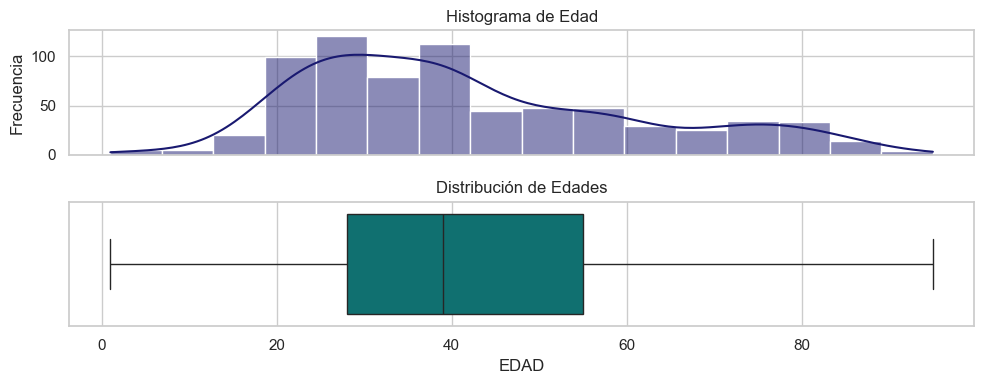

In [157]:
# Crear subgráficos
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# Histograma para la Edad
sns.histplot(hechos_victimas['Edad'], kde=True, ax=ax[0], color='midnightblue')  # Cambia 'skyblue' por el color que desees
ax[0].set_title('Histograma de Edad')
ax[0].set_ylabel('Frecuencia')

# Boxplot Edad
sns.boxplot(x=hechos_victimas['Edad'], ax=ax[1], color='teal')  # Cambia 'salmon' por el color que desees
ax[1].set_title('Distribución de Edades')
ax[1].set_xlabel('EDAD')

plt.tight_layout()
plt.show()

In [158]:
hechos_victimas['Edad'].describe()

count    717.000000
mean      42.101813
std       19.081623
min        1.000000
25%       28.000000
50%       39.000000
75%       55.000000
max       95.000000
Name: Edad, dtype: float64

Con los graficos podemosconfirmar que el 75% de los accidentados es menor de 55 años, con una media de 39 años. 
No se miran valores atípicos presentes en el boxplot, el minimo es de 1 año y el máximo de 95 años, esto se debe al registro de todas las víctimas, es decir, tanto conductores, como acompañantes y/o peatones.
Gracias al histograma podemos ver un leve sesgo al lado derecho, lo que nos indica que la gran mayoría de involucrados están entre los 20 y 40 años.


    Edades por año:

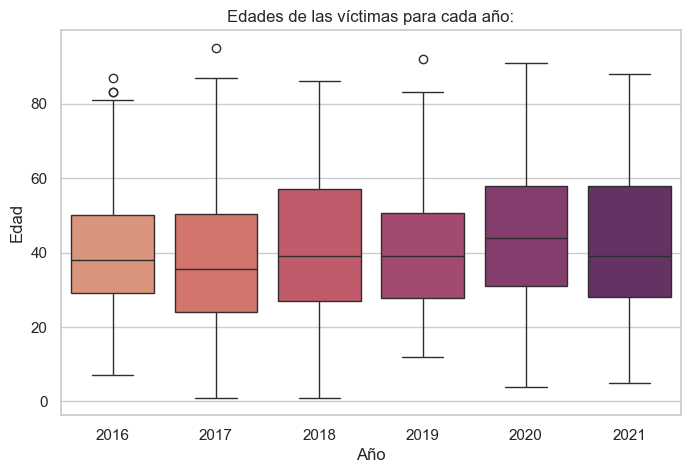

In [159]:
palette = sns.color_palette("flare", n_colors=len(hechos_victimas['Año'].unique()))

#Grafico Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Año', y='Edad', data=hechos_victimas, palette=palette)

plt.title('Edades de las víctimas para cada año:')
plt.xlabel('Año')
plt.ylabel('Edad')

plt.show()


La distribución de edad a lo largo de los años es muy similar, como ya se observó anteriormente, la media ronda los 40 años, y se observan tambien algunos valores 'atípicos', que corresponden a personas de edad muy avanzada víctimas de estos accidentes.

    Edad y Sexo de las víctimas:

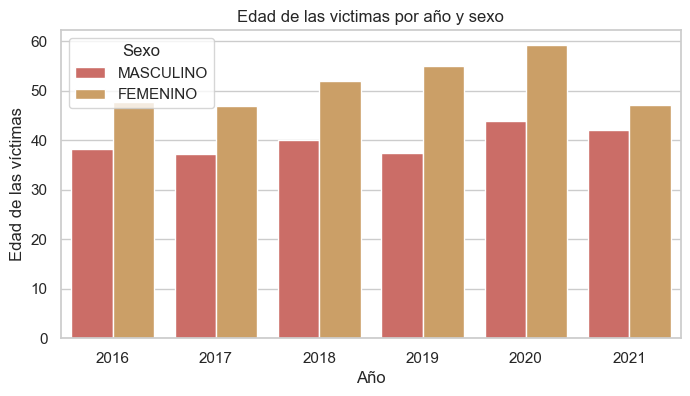

In [160]:
#Grafico de Barras
plt.figure(figsize=(8, 4))
sns.barplot(x='Año', y='Edad', hue='Sexo', data=hechos_victimas,ci = None, 
            palette=sns.color_palette("hls", n_colors=len(hechos_victimas['Año'].unique()) * len(hechos_victimas['Sexo'].unique())))

plt.title('Edad de las victimas por año y sexo')
plt.xlabel('Año')
plt.ylabel('Edad de las víctimas')
plt.legend(title='Sexo')

plt.show()

Se puede ifentificar claramente una tendencia en las edades para las victimas de sexo masculino, se observa qué, en general, las victimas de este sexo son mayores que las victimas del sexo opuesto.

Observemos también la cantidad de víctimas por sexo y año:

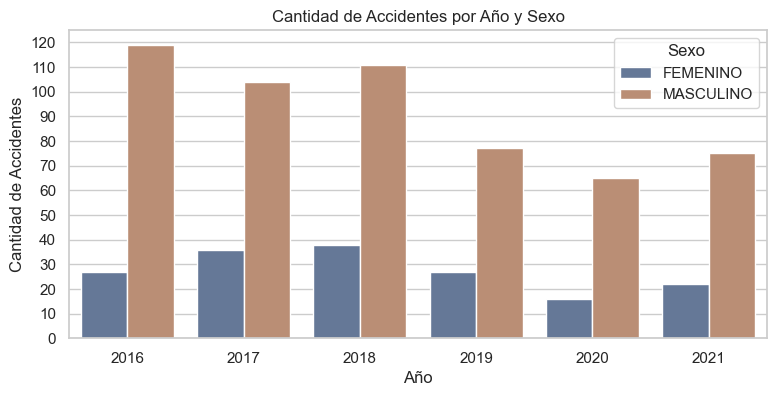

In [161]:
#Grafico de barras:

sns.set(style="whitegrid")
plt.figure(figsize=(9, 4))

sns.barplot(x='Año', y='Cantidad accidentes', hue='Sexo',
            data=hechos_victimas.groupby(['Año', 'Sexo']).size().reset_index(name='Cantidad accidentes'), saturation=0.5)

plt.title('Cantidad de Accidentes por Año y Sexo')
plt.xlabel('Año')
plt.yticks(range(0,130, 10))
plt.ylabel('Cantidad de Accidentes')
plt.legend(title='Sexo')

# Muestra el gráfico
plt.show()

Se observa que la mayoría de víctimas son de sexo Masculino, en todos los años hay una marcada diferencia entre la cantidad de victimas por cada sexo, sin embargo, el año con mayor diferencia fue el 2016.

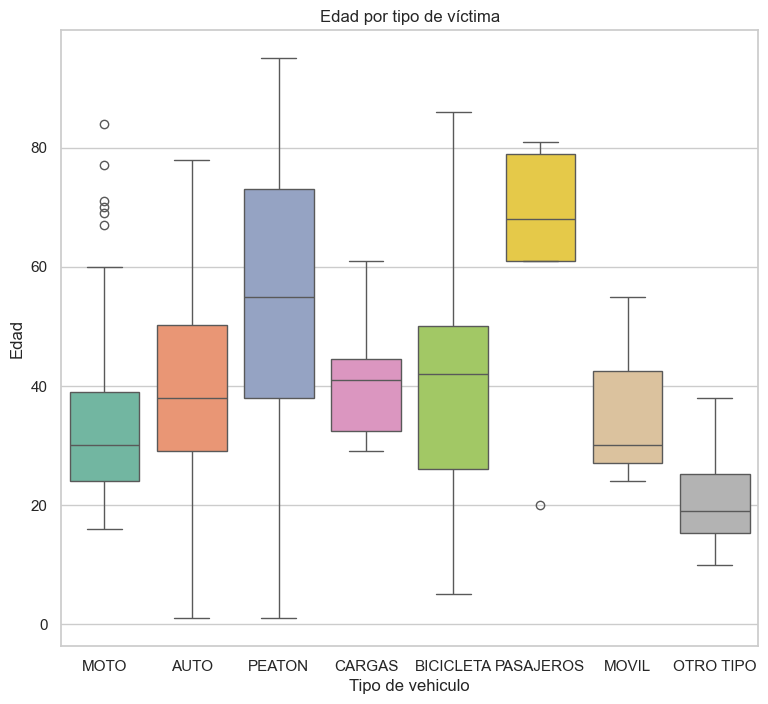

In [162]:
# Se crea el gráfico de boxplot
plt.figure(figsize=(9, 8))
sns.boxplot(x='Víctima', y='Edad', data=hechos_victimas, palette = sns.color_palette("Set2", n_colors=len(hechos_victimas['Víctima'].unique())) )
    
plt.title('Edad por tipo de víctima')  
plt.xlabel('Tipo de vehiculo') 
plt.ylabel('Edad')
     
plt.show()

Lo más destacable segun la edad por tipo de vehículo, es que la dispersion de datos para los peatones es la mayor de todas; las victimas que iban en Moto y 'Otro tipo' son las de menor edad, y los pasajeros son los que mayor edad tienen en general.

    Distribucion temporal de los hechos:

Anualmente:

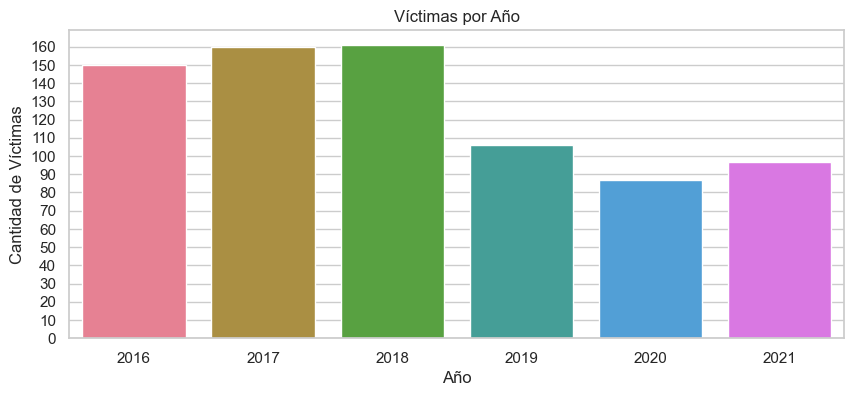

In [163]:
victimas_año = hechos_victimas.groupby("Año")["N Victimas"].sum().reset_index()
plt.figure(figsize=(10, 4))
sns.barplot(data=victimas_año, x="Año", y="N Victimas",palette="husl")
plt.title("Víctimas por Año")
plt.xlabel("Año")
plt.yticks(range(0,170, 10))
plt.ylabel("Cantidad de Víctimas")

plt.show()

Se observan una gran cantidad de victimas en los tres primeros años, y un descenso en el numero de las mismas para los años 2019-2021, esto puede deberse a la pandemia mundial que se presentó en esta época y que limitó la movilidad a nive lmundial.

Mensualmente:

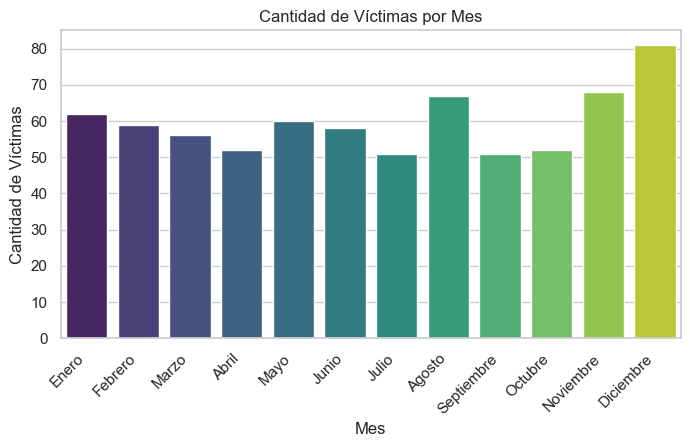

In [164]:
#Cantidad de víctimas por mes
victimas_por_mes = hechos_victimas.groupby('Mes').size().reset_index(name='Cantidad de Víctimas')

meses_dict = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
              7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'}

victimas_por_mes['Mes'] = victimas_por_mes['Mes'].map(meses_dict)

# Grafico de barras
plt.figure(figsize=(8, 4))
sns.barplot(x='Mes', y='Cantidad de Víctimas', data=victimas_por_mes, palette='viridis')

plt.title('Cantidad de Víctimas por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Víctimas')

# Rotar las etiquetas para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')

plt.show()


Se nota una tendencia de mayor riesgo en los meses de Diciembre, Agosto y Noviembre. Talvez existan eventos nacionales, internacionales o regionales que inciten a una mayor movilidad en estos meses y que causan un mayor indice de accidentes.

Semestralmente:

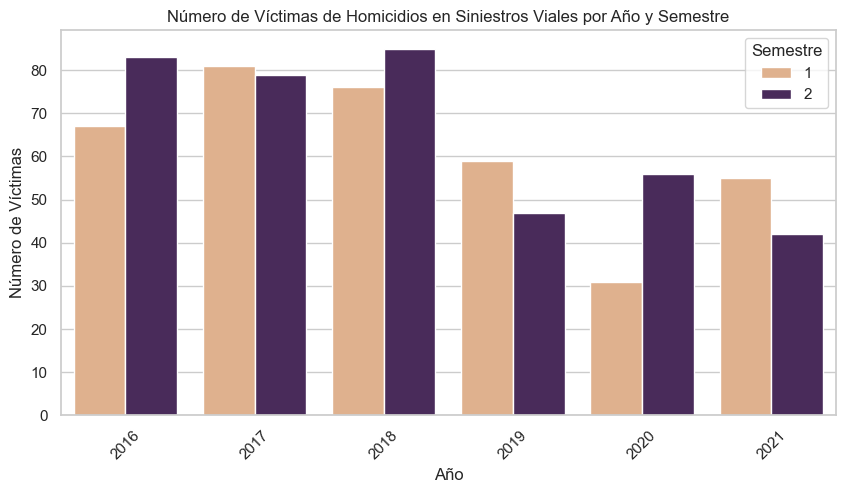

In [165]:
def num_semestre(mes):
    if mes <= 6:
        return 1
    else:
        return 2

hechos_victimas["Semestre"] = hechos_victimas["Mes"].apply(num_semestre)
semestres = hechos_victimas.groupby(["Año", "Semestre"])["N Victimas"].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data = semestres, x="Año", y="N Victimas", hue="Semestre",palette = 'flare')
plt.title("Número de Víctimas de Homicidios en Siniestros Viales por Año y Semestre")
plt.xlabel("Año")
plt.ylabel("Número de Víctimas")
plt.xticks(rotation=45)
plt.legend(title="Semestre")
plt.show()

En los años 2016, 2018 y 2020 la mayoria de accidentes ocurrieron en el segundo semestredel año, mientras que en los años 2017, 2019 y 2021 estos ocurrieron en el primer semestres del año, a primera vista no se puede detectar un patrón o causas para este comportamiento. 

Semanalmente:

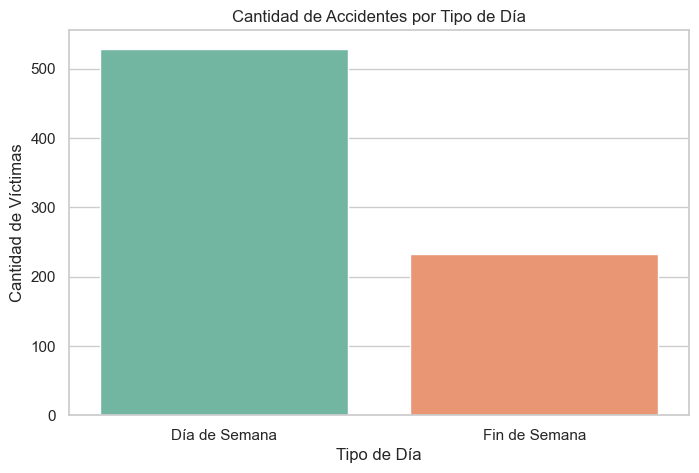

In [166]:
# Se convierte la columna 'Fecha' a tipo de dato datetime
hechos_victimas['Fecha'] = pd.to_datetime(hechos_victimas['Fecha'])

hechos_victimas['Día semana'] = hechos_victimas['Fecha'].dt.dayofweek

dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
hechos_victimas['Nombre día'] = hechos_victimas['Día semana'].map(lambda x: dias_semana[x])

#Se categoriza si es un día de semana o fin de semana
hechos_victimas['Tipo de Día'] = hechos_victimas['Día semana'].apply(lambda x: 'Fin de Semana' if x >= 5 else 'Día de Semana')

#Cantidad de víctimas por tipo de día
datos = hechos_victimas.groupby('Tipo de Día').agg({'N Victimas': 'sum'}).reset_index()

#Gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Tipo de Día', y='N Victimas', data=datos, palette='Set2')

ax.set_title('Cantidad de Accidentes por Tipo de Día')
ax.set_xlabel('Tipo de Día')
ax.set_ylabel('Cantidad de Víctimas')

plt.show()

Se observa que los accidentes son mucho mas frecuentes en semana que en los fines de semana, esto puede deberse a que durante la semana se movilizan muchas mas personas, por trabajo y estudios, y por ende mayor cantidad y variedad de vehiculos.

    Calles mas peligrosas:

Es útil conocer la calle con mayor cantidad de accidentes registrados, esto ayuda a determinar si los hechos son aislados o se concentran en un lugar en especifico:

In [167]:
calles = hechos_victimas["Calle"].value_counts()
calles.head(10)

Calle
PAZ, GRAL. AV.                                61
RIVADAVIA AV.                                 20
DEL LIBERTADOR AV.                            19
AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI    14
AUTOPISTA PERITO MORENO                       13
ALBERDI, JUAN BAUTISTA AV.                    13
AUTOPISTA 25 DE MAYO                          12
SAN MARTIN AV.                                11
CORRIENTES AV.                                11
CORDOBA AV.                                   10
Name: count, dtype: int64

Cómo se observa, la calle con mayor cantidad de hechos es Gral. Paz, esto puede deberse principalmente  a que es una vía muy extensa que abarca gran parte de la ciudad.

    Comunas:
    

Para tener una vista más general de los lugares de los hechos se analiza la cantidad de accidentes por comuna:

In [168]:
hechos_victimas.groupby(["Comuna"])["N Victimas"].sum().reset_index()

,Comuna,N Victimas
0,0,2
1,1,101
2,2,25
3,3,48
4,4,85
5,5,22
6,6,24
7,7,66
8,8,71
9,9,79


Debido a que en la comuna 0 se tienen apenas 2 casos, se decide ignorar esta comuna.

In [169]:
hechos_victimas.drop(hechos_victimas[hechos_victimas["Comuna"] == 0].index, inplace=True)

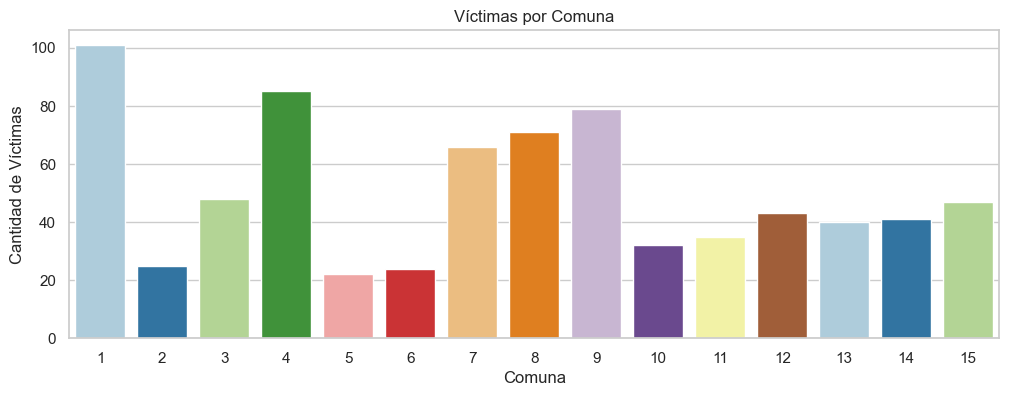

In [170]:
vic_comuna = hechos_victimas.groupby("Comuna")["N Victimas"].sum().reset_index()

plt.figure(figsize=(12, 4))

#Grafico de barras
sns.barplot(data=vic_comuna, x="Comuna", y="N Victimas",palette = 'Paired')
plt.title("Víctimas por Comuna")
plt.xlabel("Comuna")
plt.ylabel("Cantidad de Víctimas")

plt.show()

Se observa que las comunas con mayores casos son la 1, 4 y 9.

    Gral. Paz


Se observó que esta calle es la que cuenta con mayor cantidad de accidentes, por lo que se observa su comportamiento en el tiempo:

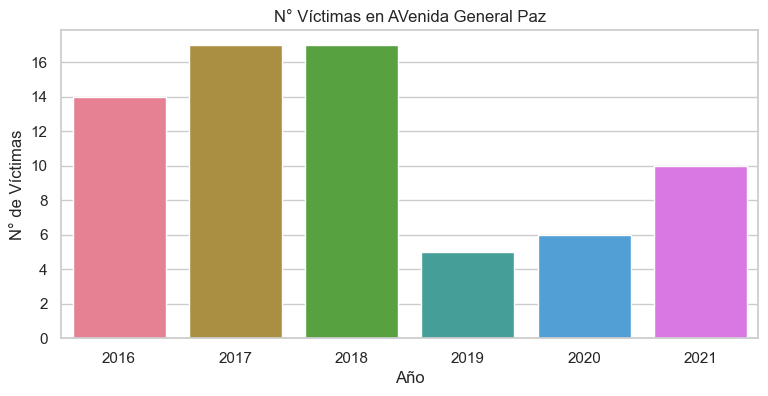

In [171]:
#Filtramos solamente para G.PAZ
G_paz = hechos_victimas[hechos_victimas["Calle"] == "PAZ, GRAL. AV."]

Gpazyear = G_paz.groupby("Año")["N Victimas"].sum().reset_index()

#Grafico de barras
plt.figure(figsize=(9, 4))
sns.barplot(data=Gpazyear,x="Año", y="N Victimas",palette ='husl')
plt.xlabel("Año")
plt.ylabel("N° de Víctimas")
plt.title("N° Víctimas en AVenida General Paz")

plt.show()

No se puede reconocer un comportamiento o tendencia general a lo largo de los años, sin embargo los datos se asemejan al comportamiento general de los siniestros a lo largo de los años.

        Tipo de Victimas:

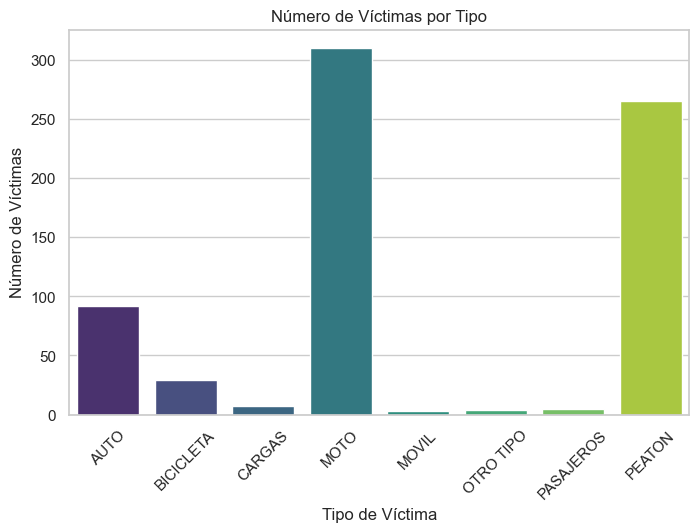

In [172]:
victimas_por_tipo = hechos_victimas.groupby('Víctima').size().reset_index(name='Número de Víctimas')

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x='Víctima', y='Número de Víctimas', data=victimas_por_tipo, palette='viridis')

plt.title('Número de Víctimas por Tipo')
plt.xlabel('Tipo de Víctima')
plt.ylabel('Número de Víctimas')
plt.xticks(rotation=45)

plt.show()

Se aprecia claramente que existe una gran cantidad de Victimas para las categorias Moto y Peaton, esto puede deberse principalmente a que son este tipo de víctimas, las que mas expuestas están, ya que no cuentan con todala seguridad que puede ofrecer, por ejemplo, un vehiculo.

        Por tipo de ACusado:

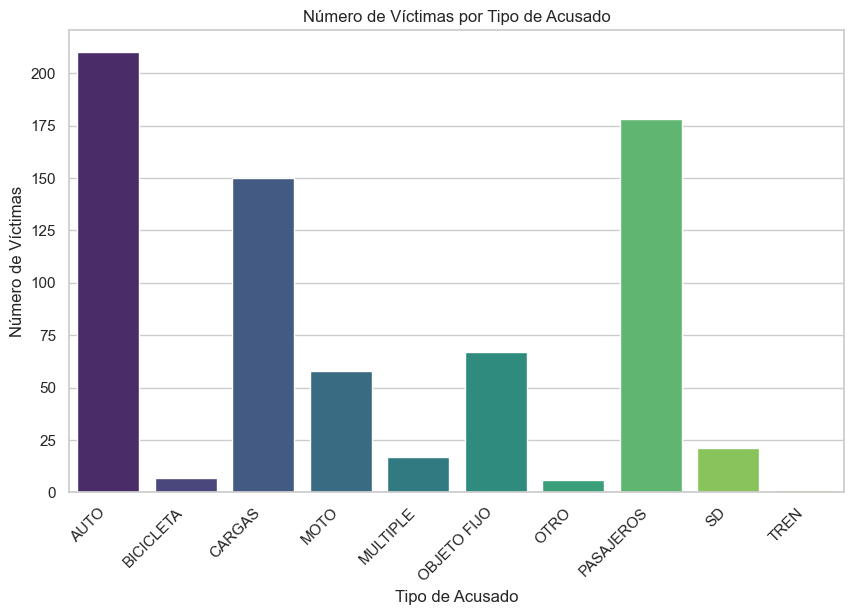

In [173]:
victimas_por_acusado = hechos_victimas.groupby('Acusado').size().reset_index(name='Número de Víctimas')

#Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Acusado', y='Número de Víctimas', data=victimas_por_acusado, palette='viridis')

# Agregar etiquetas y título
plt.title('Número de Víctimas por Tipo de Acusado')
plt.xlabel('Tipo de Acusado')
plt.ylabel('Número de Víctimas')

plt.xticks(rotation=45, ha='right')

plt.show()

La mayoría de victimas tienen por acusados a Autos, vehiculos de CArga y Pasajeros (esto indica que el hecho ocurrido se asocia a una persona que subía, bajaba o se trasladaba por algún medio de transporte público).

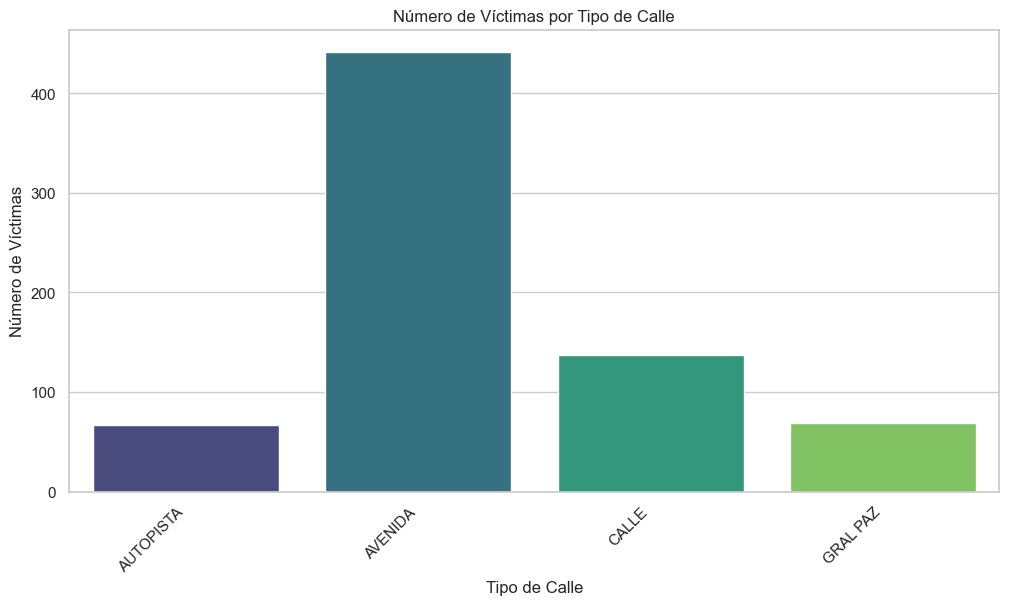

In [174]:
# Agrupar por 'Tipo De Calle' y contar número de víctimas
victimas_por_tipo_calle = hechos_victimas.groupby('Tipo De Calle').size().reset_index(name='Número de Víctimas')

#Grafico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Tipo De Calle', y='Número de Víctimas', data=victimas_por_tipo_calle, palette='viridis')

plt.title('Número de Víctimas por Tipo de Calle')
plt.xlabel('Tipo de Calle')
plt.ylabel('Número de Víctimas')

plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.show()

Finalmente, se tiene que la gran mayoría de hechos se dan en Avenidas, esto se debe a que estan son vías grandes que abarcan grandes cantidades de superficie en la ciudad, por lo que es mas probable que ocurran siniestros en este tipo de calles.

            Cantidad de victimas por cruce:

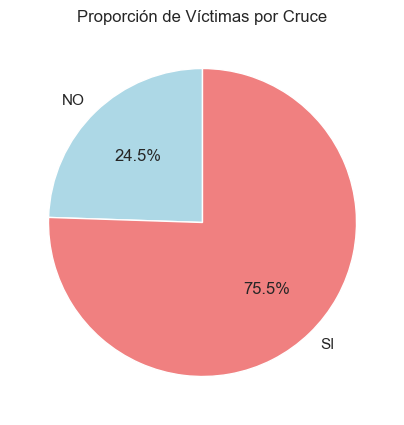

In [175]:
# Agrupar por  'Cruce' y contar número de víctimas
victimas_por_cruce = hechos_victimas.groupby('Cruce').size()

#Gráfico de torta
plt.figure(figsize=(5, 5))
plt.pie(victimas_por_cruce, labels=victimas_por_cruce.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])

plt.title('Proporción de Víctimas por Cruce')

# Mostrar el gráfico
plt.show()

Se puede evidenciar que el numero de victimas aumenta drasticamente cuando existe un cruce, estos suelen ser puntos críticos en el flujo de tráfico, donde múltiples vehículos pueden converger. El aumento en la cantidad de vehículos puede contribuir a un mayor riesgo de choques y víctimas. En algunos cruces puede no haber semáforos, algunos conductores irresponsables pueden saltarse la señal de Pare, lo que tambien contribuye a este alto indice de accidentes.

In [176]:
csv = '../csvs/hechos_y_victimas.csv'
hechos_victimas.to_csv(csv, index=False, encoding='utf-8')